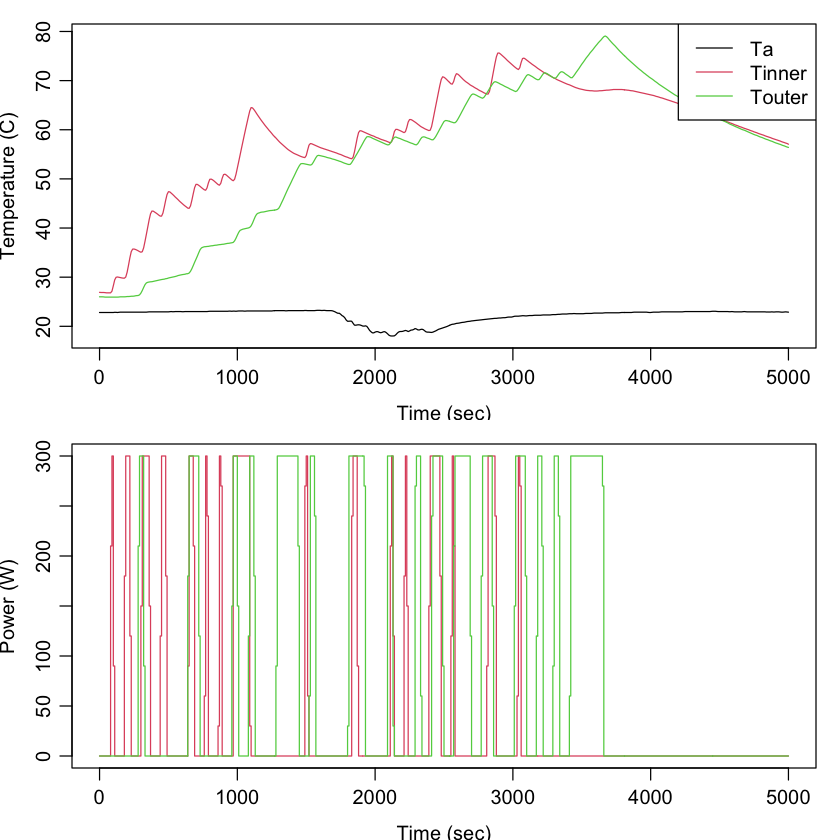

In [20]:
# ----------------------------------------------------------------
## @knitr ReadAndPlot

## Source the files in the "functions" folder
files <- dir("functions",full.names=TRUE)
for(i in 1:length(files)) source(files[i])


# Read the data
X <- read.table("data/experiment1.csv", sep=",", header=TRUE)
X$t <- X$t - X$t[1]

# Make one plot of the time series
par(mfrow=c(2,1), mgp=c(2.2,0.7,0), mar=c(3,3,1,1),bg = "white")
plot(X$t, X$Ta, ylim=range(X$Ta,X$Tinner,X$Touter), type="l", xlab="Time (sec)", ylab="Temperature (C)")
lines(X$t, X$Tinner, col=2)
lines(X$t, X$Touter, col=3)
legend("topright", c("Ta","Tinner","Touter"), lty=1, col=1:3)
plot(X$t, X$Pinner, ylim=range(X$Pinner,X$Pouter), type="s", xlab="Time (sec)", ylab="Power (W)", col=2)
lines(X$t, X$Pouter, col=3, type="s")


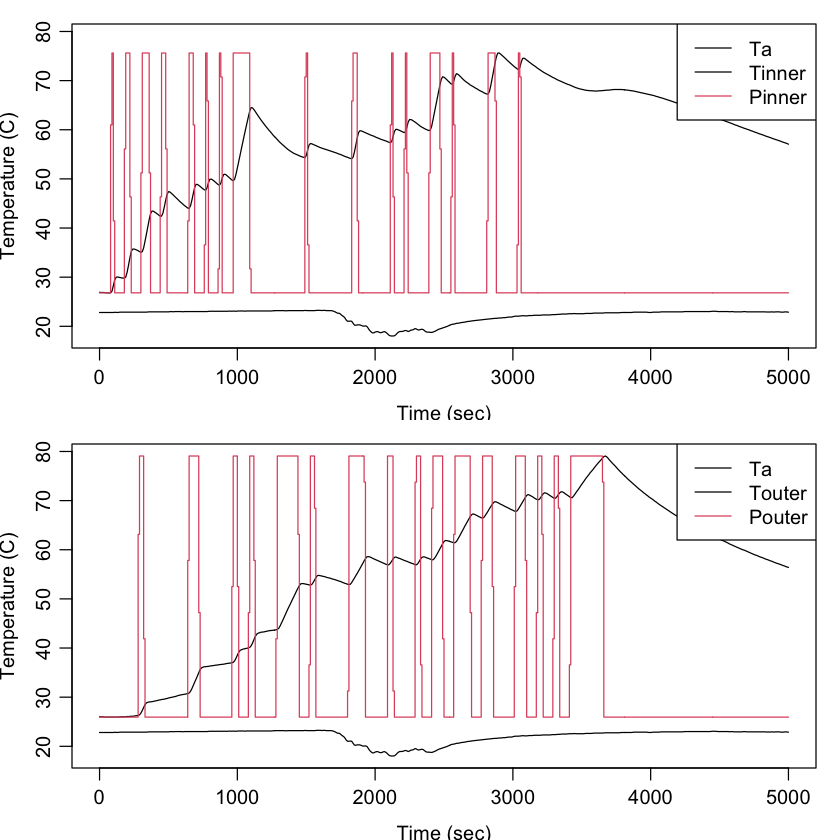

In [21]:

# Make another plot of the time series
par(mfrow=c(2,1), mgp=c(2.2,0.7,0), mar=c(3,3,1,1),bg="white")
ylim <- range(X$Ta,X$Tinner,X$Touter)
plot(X$t, X$Tinner, ylim=ylim, type="l", xlab="Time (sec)", ylab="Temperature (C)")
lines(X$t, X$Ta)
lines(X$t, (X$Pinner/max(X$Pinner,na.rm=TRUE))*diff(range(X$Tinner))+min(X$Tinner,na.rm=TRUE), type="s", col=2)
legend("topright", c("Ta","Tinner","Pinner"), lty=1, col=c(1,1,2))
plot(X$t, X$Touter, ylim=ylim, type="l", xlab="Time (sec)", ylab="Temperature (C)")
lines(X$t, (X$Pouter/max(X$Pouter,na.rm=TRUE))*diff(range(X$Touter))+min(X$Touter,na.rm=TRUE), type="s", col=2)
lines(X$t, X$Ta)
legend("topright", c("Ta","Touter","Pouter"), lty=1, col=c(1,1,2))
# ----------------------------------------------------------------



[1] 1

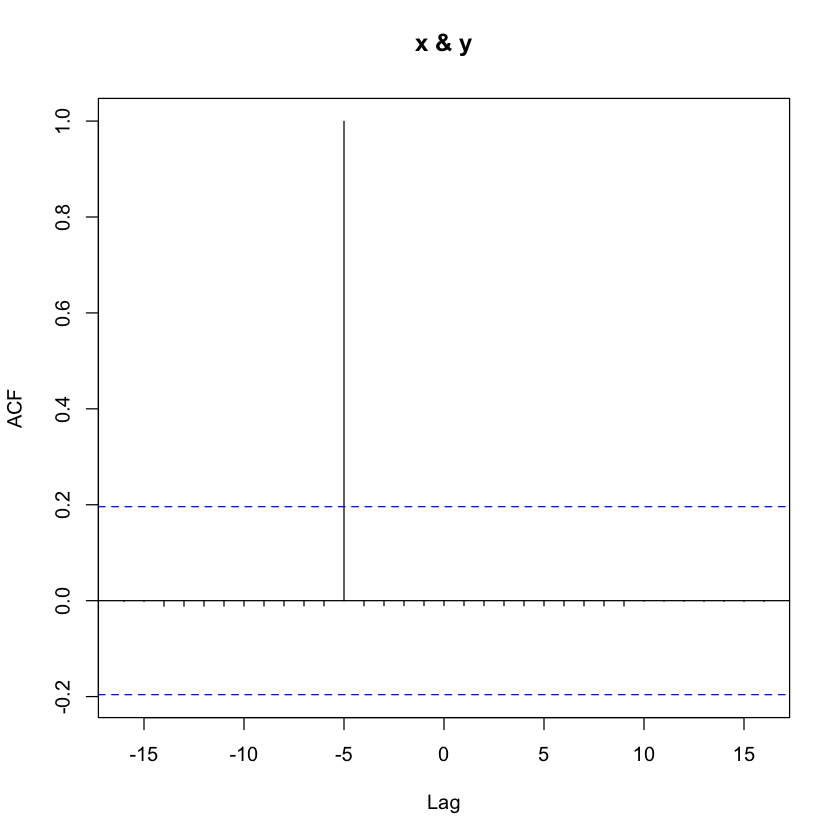

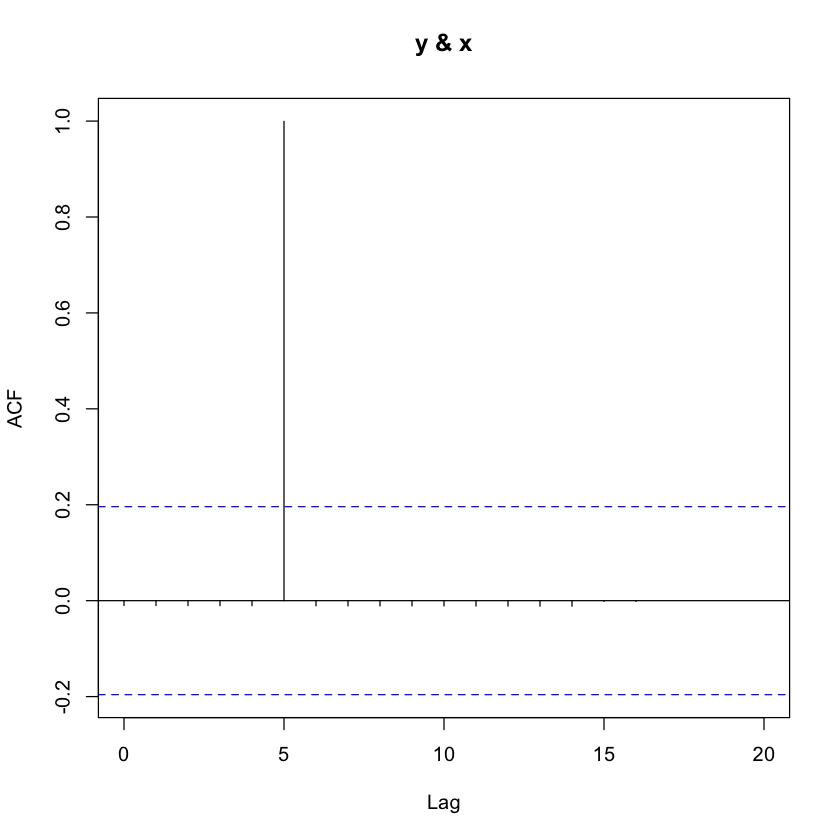

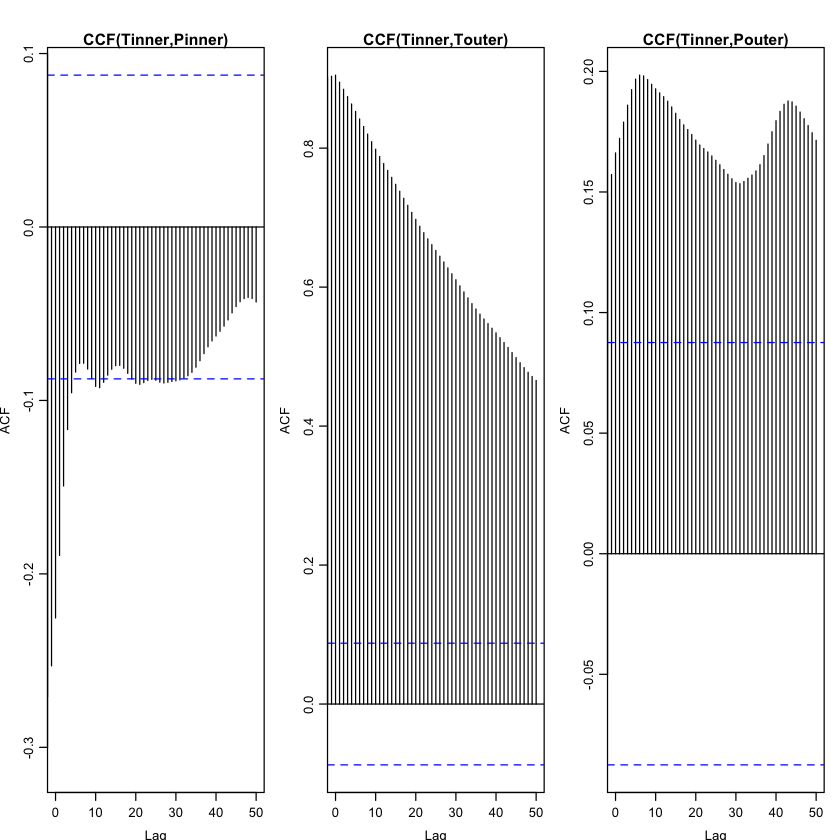

In [22]:

# ----------------------------------------------------------------
## @knitr CCFs
# Consider the how to make the CCF as impulse response from x to y!
# Make y a delayed version of x 5 steps.
x <- y <- rep(0, 100)
x[10] <- 1
y[15] <- 1

ccf(x,y)

cor(lagvec(x,5), y, use="complete.obs")
# So for "impulse response" from x to y, use the ccf function like this

ccf(y,x, xlim=c(0,20))

# CCFs of the experiment variables
ccf2 <- function(x, y, lag.max=50, xlim=c(0,50), main=""){
  ccf(x,y, lag.max=lag.max, xlim=xlim, main="")
  title(main=main, line=0.2)
}
par(mfrow=c(1,3), mgp=c(2.2,0.7,0), mar=c(3,3,3,1),bg="white")
ccf2(X$Tinner, X$Pinner, main="CCF(Tinner,Pinner)")
ccf2(X$Tinner, X$Touter, main="CCF(Tinner,Touter)")
ccf2(X$Tinner, X$Pouter, main="CCF(Tinner,Pouter)")
# ----------------------------------------------------------------


[1] "Tinner ~ 0 + Tinner.l1 + Ta.l1"

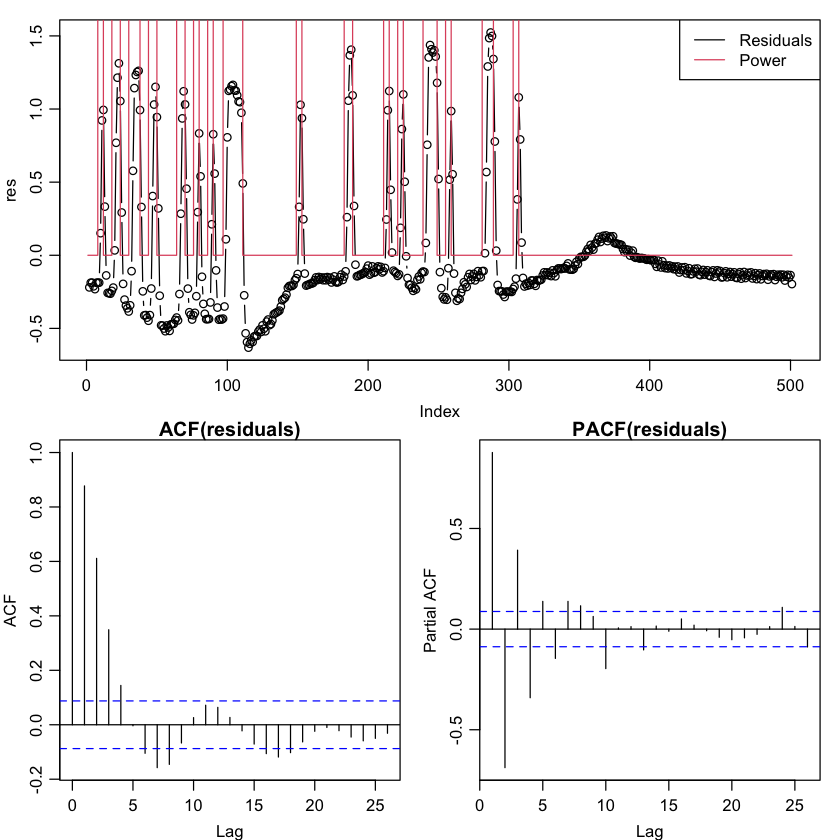

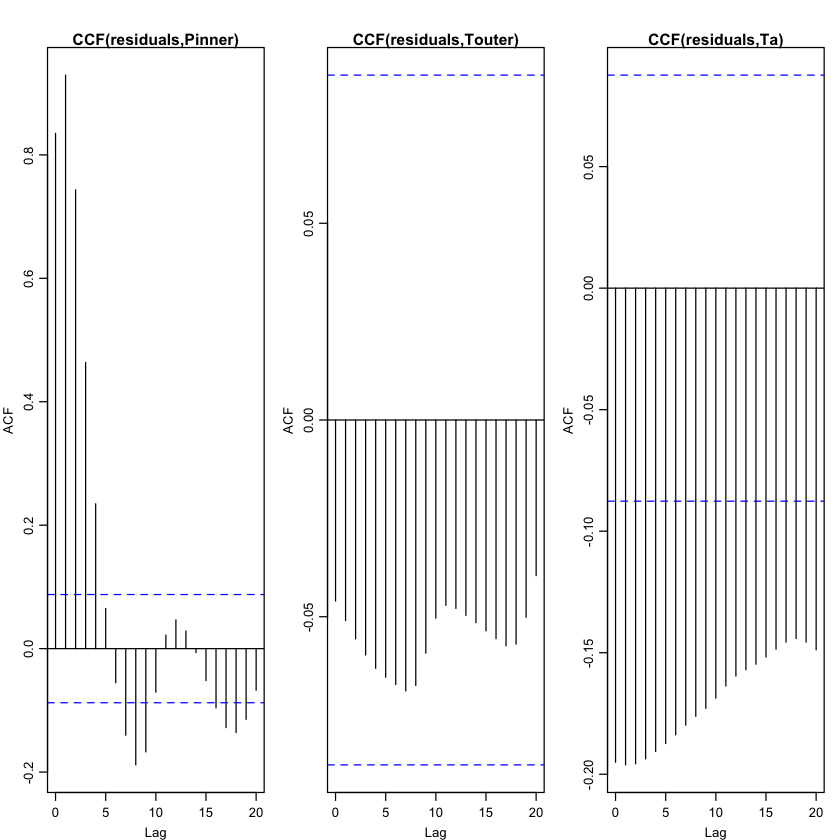

In [23]:
# ----------------------------------------------------------------
## @knitr ARX1
# Make lags
maxlag <- 10
for(i in 1:maxlag){
  tmp <- lagdf(X[ ,2:6], i)
  names(tmp) <- paste0(names(tmp),".l",i)
  X <- cbind(X, tmp)
}

# For keeping fits
L <- list()

# Check the code of functions/ARX.R to see how it generates the formula for an ARX for lm()
ARX("Tinner", c("Ta"), lags=1)
    
# Fit and print
L$ARX1 <- lm(ARX("Tinner", c("Ta"), lags=1), data=X)
# To add more inputs, replace with the name of the variable
L$ARX1 <- lm(ARX("Tinner", c("Ta","Touter"), lags=1), data=X)
#summary(L$ARX1)

# Validate residuals
par(bg = "white")
validate(L$ARX1)
par(bg = "white")
ccfplot(L$ARX1, X)

# Add more inputs to the ARX1 model, until you are happy with the validation

# Check the code of functions/ARX.R to see how it generates the formula for an ARX for lm()
# ----------------------------------------------------------------


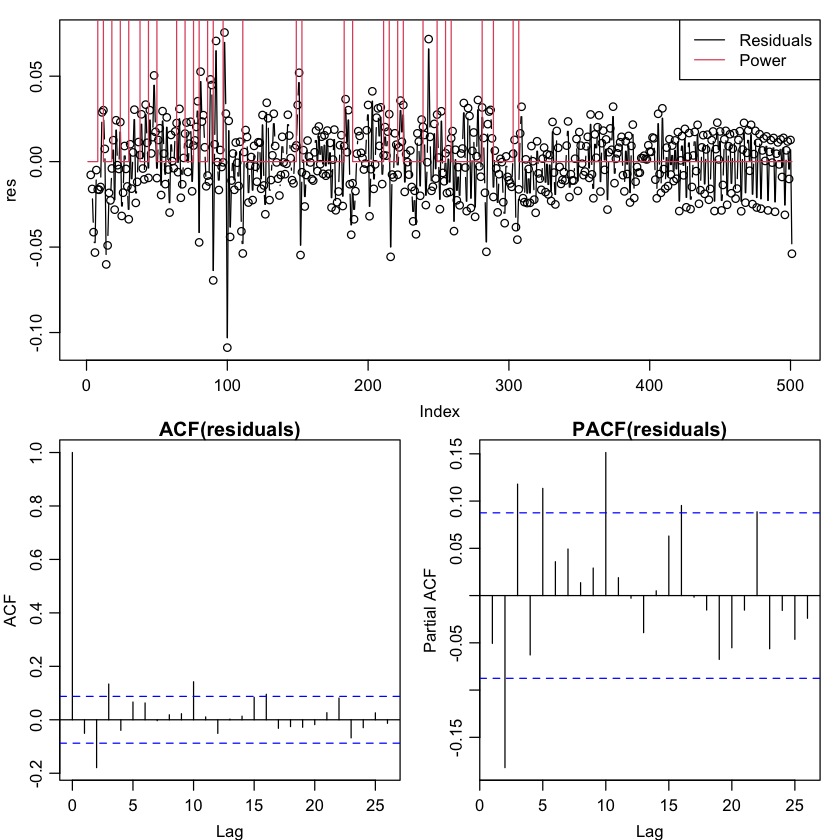


Call:
lm(formula = ARX("Tinner", c("Ta", "Touter", "Pinner"), lags = 1:2), 
    data = X)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.10883 -0.01409  0.00173  0.01422  0.07554 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
Tinner.l1  1.264e+00  4.601e-03 274.744   <2e-16 ***
Tinner.l2 -2.774e-01  4.560e-03 -60.827   <2e-16 ***
Ta.l1     -6.106e-04  1.381e-02  -0.044    0.965    
Ta.l2      5.160e-03  1.377e-02   0.375    0.708    
Touter.l1  5.426e-03  4.100e-03   1.323    0.186    
Touter.l2  4.938e-03  4.049e-03   1.220    0.223    
Pinner.l1  1.604e-03  1.792e-05  89.489   <2e-16 ***
Pinner.l2  2.356e-03  2.936e-05  80.256   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02137 on 491 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 4.981e+08 on 8 and 491 DF,  p-value: < 2.2e-16


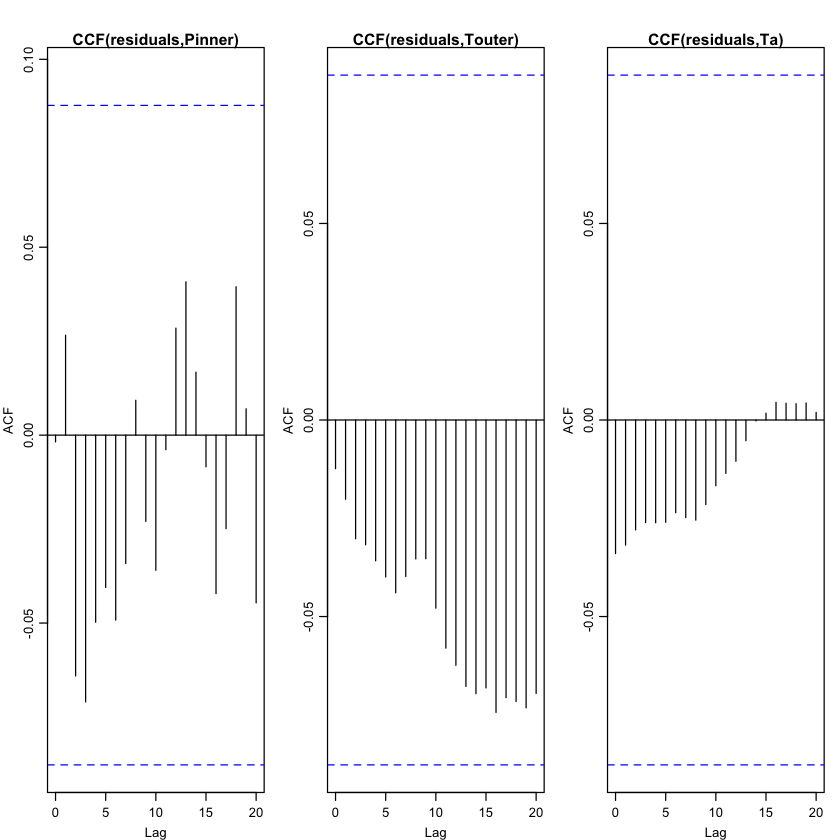

In [ ]:

# ----------------------------------------------------------------
## @knitr ARX-select

# Higher orders, REMEMBER to add inputs you identified above
# e.g.
L$ARX2 <- lm(ARX("Tinner", c("Ta","Touter","Pinner"), lags=1:2), data=X)
par(bg="white")
validate(L$ARX2)
ccfplot(L$ARX2, X)
summary(L$ARX2)

# Keep adding higher orders or different models to the list, as you later can run through it
# e.g.
L$ARX3 <- lm(ARX("Tinner", c("Ta","Pinner","Touter"), lags=1:3),data=X)
# ----------------------------------------------------------------



[1] -75.29528
[1] -2411.938
[1] -2416.617
[1] -54.22224
[1] -2374.024
[1] -2361.879


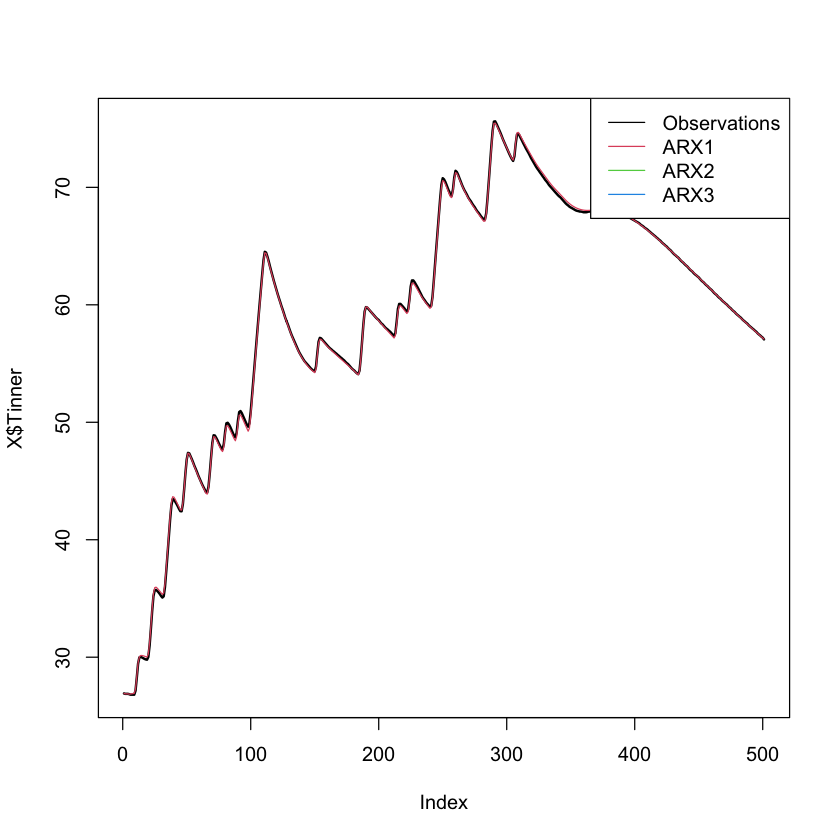

In [30]:
# ----------------------------------------------------------------
## @knitr ARX-select-AICBIC
for(i in 1:length(L)){
  print(AIC(L[[i]]))
}

for(i in 1:length(L)){
  print(BIC(L[[i]]))
}
L$ARX1 <- lm(ARX("Tinner", c("Ta","Touter","Pinner"), lags=1:2), data=X)
L$ARX2 <- lm(ARX("Tinner", c("Ta","Touter","Pinner"), lags=1:2), data=X)
L$ARX3 <- lm(ARX("Tinner", c("Ta","Pinner","Touter"), lags=1:3),data=X)
# Do a multi-step prediction (i.e. use the observed inputs, but calculate the AR part iteratively)
# Do it for all the models you included in L
par(bg="white")
plot(X$Tinner, type="l", lwd=2)         
for(i in 1:1){
  lines(arxmulti(5, L[[i]], X), col=i+1)
}
legend("topright", c("Observations",names(L)), lty=1, col=1:(length(L)+1))
# ----------------------------------------------------------------


In [31]:
# Which order would you select?
# ----------------------------------------------------------------


# ----------------------------------------------------------------
## @knitr ARX-multistep-prediction
# ----------------------------------------------------------------
## @knitr Install-marima
# Use marima (in a modified version to make the model formula easier)
library(marima2)

# ----------------------------------------------------------------


# ----------------------------------------------------------------
# @knitr ARMAX-select
L$ARMAX1 <- marima("Tinner ~ AR(1) + AR(12) + Ta(1) + Touter(3) +MA(5)", data=X)
L$ARMAX2 <- marima("Tinner ~ AR(1:2) + Ta(1)", data=X)
L$ARMAX3 <- marima("Tinner ~ AR(1:3) + Ta(1)", data=X)
L$ARMAX4 <- marima("Tinner ~ AR(1:4) + Ta(1)", data=X)
L$ARMAX5 <- marima("Tinner ~ AR(1:5) + Ta(1)", data=X)


All cases in data,  1  to  501  accepted for completeness.
501 3  = MARIMA - dimension of data 
All cases in data,  1  to  501  accepted for completeness.
501 2  = MARIMA - dimension of data 
All cases in data,  1  to  501  accepted for completeness.
501 2  = MARIMA - dimension of data 
All cases in data,  1  to  501  accepted for completeness.
501 2  = MARIMA - dimension of data 
All cases in data,  1  to  501  accepted for completeness.
501 2  = MARIMA - dimension of data 


[1] 1

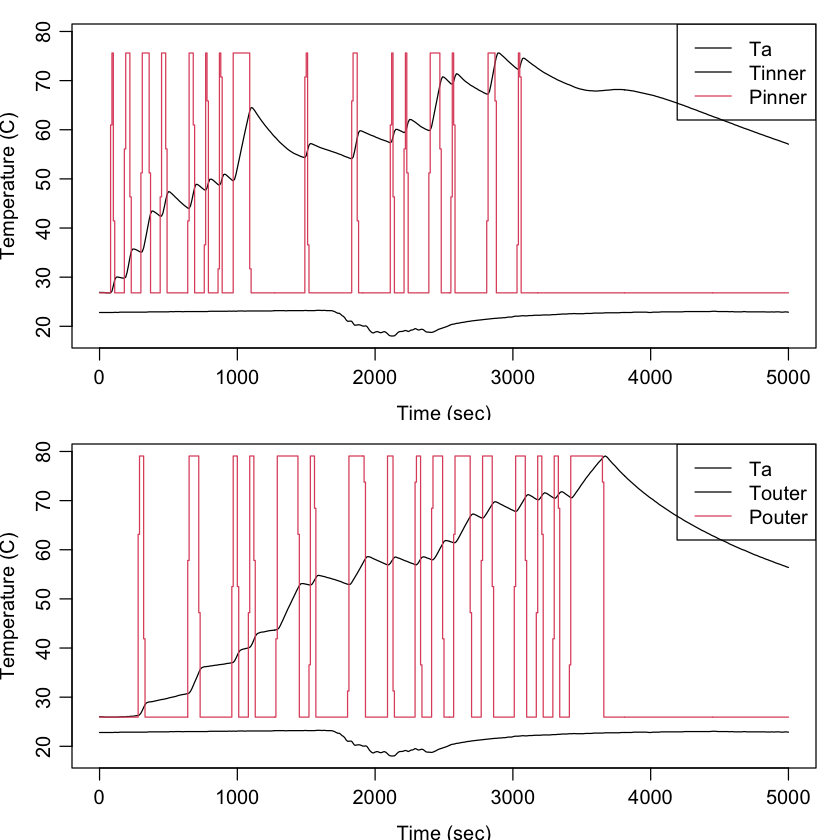

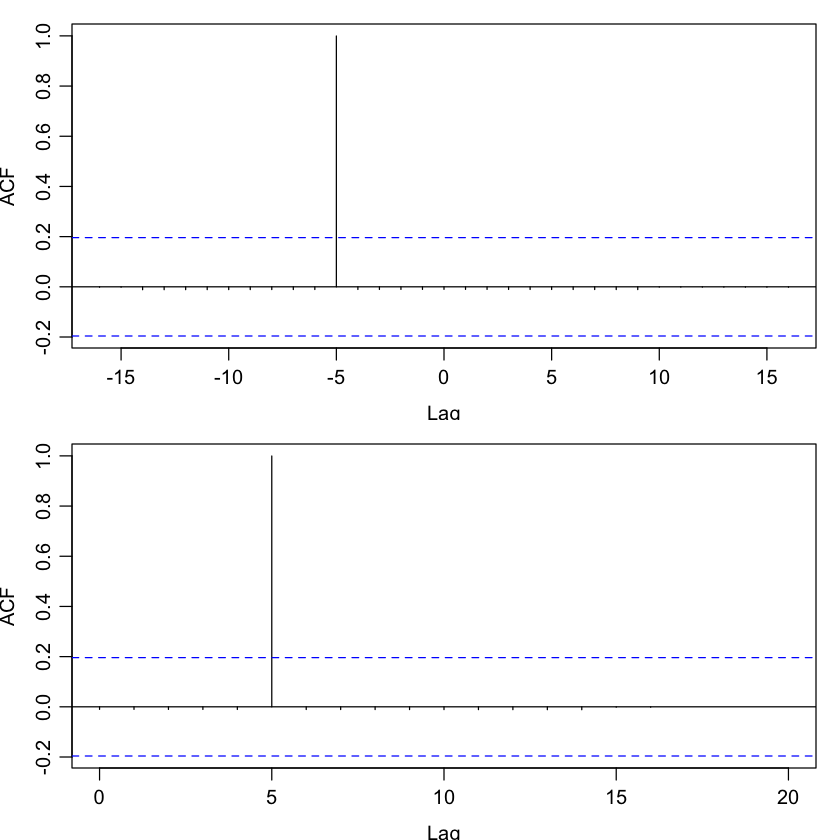

[1] "Tinner ~ 0 + Tinner.l1 + Ta.l1"

ERROR: Error in eval(predvars, data, env): objekt 'NAME_OF_NEW_INPUT.l1' blev ikke fundet


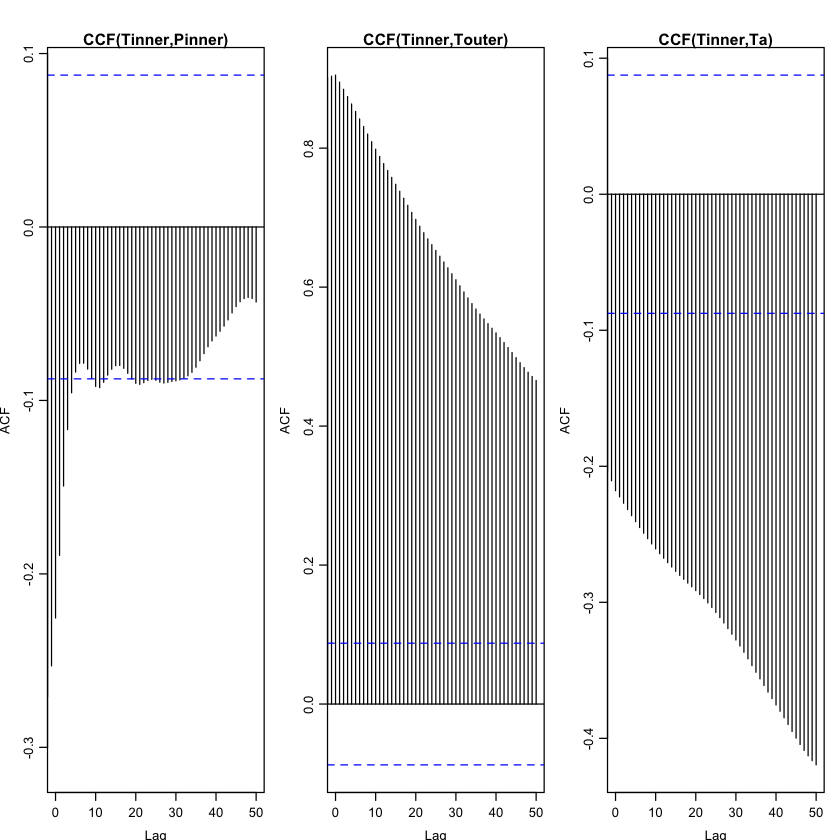

In [3]:





#summary(L$ARMAX1)
#summary(L$ARMAX2)
summary(L$ARMAX3)
#summary(L$ARMAX4)
#summary(L$ARMAX5)

# Note not totally on same values! So it's actually not possible right out of the box to use it!
length(L$ARMAX1$lmfits[[1]]$residuals)
length(L$ARMAX2$lmfits[[1]]$residuals)
AIC(L$ARMAX1$lmfits[[1]])
AIC(L$ARMAX2$lmfits[[1]])
AIC(L$ARMAX3$lmfits[[1]])
AIC(L$ARMAX4$lmfits[[1]])
AIC(L$ARMAX5$lmfits[[1]])

BIC(L$ARMAX1$lmfits[[1]])
BIC(L$ARMAX2$lmfits[[1]])
BIC(L$ARMAX3$lmfits[[1]])
BIC(L$ARMAX4$lmfits[[1]])
BIC(L$ARMAX5$lmfits[[1]])

# You can use the "penalty" argument, see ?marima, it will make an automatic model reduction
# Try increasing the penalty (it's the regularization coefficient, so 2 is AIC)
ARMAX <- marima("Tinner ~ AR(1:5) + Pinner(1:5) + Touter(1:5) + Ta(1:5) + MA(1:5)", data=X, penalty=2)
# Note many of the coefficients are zero (or very close), and yet very significant, so it's not working that good
summary(ARMAX)
validate(ARMAX)
# ----------------------------------------------------------------


# ----------------------------------------------------------------
# @knitr ARMAX-validate
validate(L$ARMAX2)

#summary(L$ARMAX3)
#validate(L$ARMAX3)
# ----------------------------------------------------------------


# ----------------------------------------------------------------
## @knitr ARMAX-multistep
# and Multi-step forecasts
plot(X$Tinner, type="l", lwd=3)
#
val <- predict(L$ARMAX1, nstep=nrow(X)-1)
lines(val$forecasts[1, ], type="l", col=3)
#
val <- predict(L$ARMAX2, nstep=nrow(X)-1)
lines(val$forecasts[1, ], type="l", col=4)
#
val <- predict(L$ARMAX3, nstep=nrow(X)-1)
lines(val$forecasts[1, ], type="l", col=5)
legend("topleft", c("Obs","ARX1","ARMAX1","ARMAX2","ARMAX3"), lty=1, col=1:5)
# ----------------------------------------------------------------


# ----------------------------------------------------------------
## @knitr ARMAXbivariate-select
ARMAX <- marima("Tinner ~ AR(1) + ?",
                "Touter ~ AR(1) + ?", data=X,
                penalty=0)
summary(ARMAX)
# ----------------------------------------------------------------


# ----------------------------------------------------------------
## @knitr ARMAXbivariate-multistep

Xpred <- X[ ,c("Pinner","Pouter","Ta")]
#
par(mfrow=c(2,1), mar=c(3,3,3,1), mgp=c(2, 0.7,0))
val <- predict(ARMAX, nstep=nrow(Xpred)-1)
plot(X$Tinner, type="l", lwd=3)
lines(val$forecasts[1, ], type="l", col=2)
plot(X$Touter, type="l", lwd=3)
lines(val$forecasts[2, ], type="l", col=2)
# ----------------------------------------------------------------


# ----------------------------------------------------------------
## @knitr ARMAXbivariate-step-response
input <- "Pinner"
# Simulation steps
nms <- row.names(ARMAX$DATA)
n <- 1000
Xnew <- as.data.frame(matrix(0, nrow=n, ncol=length(nms)))
names(Xnew) <- row.names(ARMAX$DATA)
# Set the inputs to the values you want
Xnew$Tinner <- 10
Xnew$Touter <- 10
Xnew$Ta <- 10
# The step
Xnew[-1:-10,input] <- Xnew[-1:-10,input] + 100
#
val <- arma.forecast(Xnew, ARMAX, 1, n-1)
#plot(M$data[ ,input], type="l")
yhat <- val$forecasts[1, ]
se <- sqrt(val$pred.var[1,1, ])
plot(yhat, type="l", ylim=c(0,100), lwd=2)
lines(yhat[-1] - qnorm(0.975)*se, lty=2)
lines(yhat[-1] + qnorm(0.975)*se, lty=2)
#
yhat <- val$forecasts[2, ]
se <- sqrt(val$pred.var[2,2, ])
lines(yhat, type="l", col=2, lwd=2)
lines(yhat[-1] - qnorm(0.975)*se, lty=2, col=2)
lines(yhat[-1] + qnorm(0.975)*se, lty=2, col=2)
#
legend("topleft", nms[1:2], lty=1, col=1:2)
# ----------------------------------------------------------------


# ----------------------------------------------------------------
## @knitr ARMAXbivariate-predict-with-new-power-sequence
## Predict with new power sequences
Ta <- 30
# Simulation steps
n <- 500
Xnew <- Xpred[1:n, ]
Xnew$Pinner <- c(rep(0,100), rep(150,200), rep(0,200))
Xnew$Pouter <- c(rep(50,200), rep(0,300))
Xnew$Ta <- 0
Xnew$Tinner <- NA # 50 would give the same, it uses only the first lags
Xnew$Touter <- NA # 0 would give the same, it uses only the first lags
Xnew$Tinner[1:4] <- 50
Xnew$Touter[1] <- 0
#
val <- predict(ARMAX, Xnew, 1, n-1)
#
par(mfrow=c(2,1))
plot(Xnew$Pinner, type="l")
lines(Xnew$Pouter, type="l", col=2)
#
yhat <- val$forecasts[1, ]
se <- sqrt(val$pred.var[1,1, ])
plot(yhat, type="l", ylim=c(0,100), lwd=2)
lines(yhat[-1] - qnorm(0.975)*se, lty=2)
lines(yhat[-1] + qnorm(0.975)*se, lty=2)
#
yhat <- val$forecasts[2, ]
se <- sqrt(val$pred.var[2,2, ])
lines(yhat, type="l", col=2, lwd=2)
lines(yhat[-1] - qnorm(0.975)*se, lty=2, col=2)
lines(yhat[-1] + qnorm(0.975)*se, lty=2, col=2)
#
legend("topleft", nms[1:2], lty=1, col=1:2)
# ----------------------------------------------------------------


# ----------------------------------------------------------------
## @knitr ARMAXbivariate-steady-state-response
gain.marima <- function(fit, output, input){
  tbl <- summary(fit)[[output]]
  -sum(tbl[grep(input,tbl$Name), "Estimate"]) / sum(1,tbl[grep("AR",tbl$Name), "Estimate"])
}
gain.marima(ARMAX, "Tinner", "Touter")
gain.marima(ARMAX, "Touter", "Tinner")

gain.marima(ARMAX, "Tinner", "Pinner")
gain.marima(ARMAX, "Touter", "Pouter")
# ----------------------------------------------------------------
